# Introducción
Este proyecto tiene el objetivo de implementar un pipeline productivo de modelos de aprendizaje automático para predecir si un cliente bancario será moroso o no y con qué probabilidad.
### Problema: Saber qué clientes caerán en mora o no.
### Datos
Los datos incluyen diversas estadísticas descriptivas tanto de la billetera del cliente como del estado del mercado, sus componentes y riesgos asociados a las transacciones, las cuales incluyen préstamos, reembolsos, entre otras.
Las variables a considerar se estudiarán mas adelante, la variable a predecir es la variable target que indica si una persona es o no morosa.
### Métrica
La principal métrica a utilizar es el Recall y F1-Score dado que en un problema de clases desbalanceadas donde nos interesa la clase minoritaria, en este caso clientes que caen en mora, principalmente nos interesa maximizar la cantidad de verdaderos morosos que el modelo detecta correctamente de la cantiodad total de morosos. El F1-Score es una métrica complementaria que nos indica el desempeño del modelo en general, asegurándonos que no pierde todo su poder de generalización por concentrarse exclusivamente en la clase morosa.
### Transformaciones
Las transformaciones relizadas fueron escalado con MaxMinScaler e imputación con la mediana a través de SimpleImputer (evitando data leakage). También se redujo la cantidad de columnas en función de la correlación entre estas y con la variable objetivo, de forma de agilizar la optimización de los modelos.
### Modelos
Los modelos utilizados son:
- Baseline: Random Forest Classifier
- Comprativos: SVClassifier, XGBoost , Logistic Regression


# Librerías

In [ ]:
!pip install ydata_profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 75.7 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=de0a6ed3fdadb61f45a2a05ab3a4533600608fa9b077de2e06b0d5d633f16faf
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
# Data framework
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Models

# Pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
# Preprocessing

# Misc
import math

# EDA
### Plan
Se seguirá la siguiente estructura de análisis de los datos que responden a distintas preguntas:
- Caracterización del dataset: ¿Qué características generales tiene el dataset?
    - Tamaño del dataset
    - Datos duplicados
    - Formato de columnas
    - Columnas con identificadores
    - Columnas categóricas y numéricas
    - Valores únicos por columna
- Distribución de las variables independientes: ¿Qué distribución siguen las variables independientes?
    - Estadísticas descriptivas por grupo y en general
- Visualización: ¿Cómo se ven los datos?
    - Univariado: Histogramas para numéricas y barras para categóricas
    - Bivariado: Boxplots por variable y por morosidad, gráficos de dispersión
- Correlaciones: ¿Hay variables más o menos importants para predecir la morosidad que otras?
    - Heatmap de correlación
    - Variables más y menos explicativas
    - Eliminación de columnas
- Outliers y valores nulos: ¿Hay valores nules o atípicos en la data?
    - Tratamiento de nulos
    - Detectar valores atípicos
- Análisis de variables categóricas: ¿Hay categorías que ayuden a discriminar entre morosos?
    - Frecuencia de categorías
    - Morosidad por segmento de variable categórica
    - Codificación de variables categóricas.
- Distribución conjunta de variables independientes: ¿Existen distribuciones conjuntas de variables independientes relevantes?
    - Análisis de distribución conjunta tanto con la independiente como entre dependientes
    - Pairplots
- Desbalanceo de clases: ¿Hay una clase prevalente por sobre la otra?
    - Técnicas de balanceo
    - Suficiencia de datos por variable y clase

## Cargamos datos

In [ ]:
# Leemos los parquet con los datos
# Agregamos la data nueva a medida que se publica
X_0 = pd.read_parquet("X_t0.parquet")
y_0 = pd.read_parquet("y_t0.parquet")
X_1 = pd.read_parquet("X_t1.parquet")
y_1 = pd.read_parquet("y_t1.parquet")
X_2 = pd.read_parquet("X_t2.parquet")
y_2 = pd.read_parquet("y_t2.parquet")
X_3 = pd.read_parquet("X_t3.parquet")

## Construimos los dataframes

In [ ]:
# Construimos la variable dependiente e independientes con los datos disponibles
# Varía dependiendo de la cantidad de datos disponibles
X = pd.concat([X_0,X_1,X_2],axis=0).reset_index(drop=True)
y = pd.concat([y_0,y_1,y_2],axis=0).reset_index(drop=True)

In [ ]:
# Construimos, además, un dataframe con todas las columnas (x e y)
df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
df.head(-20)

borrow_block_number  borrow_timestamp  \
0                   7711117      1.557197e+09   
1                   7711123      1.557197e+09   
2                   7711126      1.557197e+09   
3                   7711672      1.557205e+09   
4                   7712572      1.557217e+09   
...                     ...               ...   
354343             15269491      1.659530e+09   
354344             15269539      1.659531e+09   
354345             15269599      1.659531e+09   
354346             15269603      1.659531e+09   
354347             15269604      1.659532e+09   

                                    wallet_address  first_tx_timestamp  \
0       0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
1       0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
2       0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
3       0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6        1.557191e+09   
4       0xbd9ed130a53cfafcf81502e4d35329a6c4d53410        1.557217e+09   
...                                            ...                 ...   
354343  0x289c1a136eeab35fb96fd1a5823ee350ee15cd55        1.595178e+09   
354344  0xbfabc9c34e03ad3cdcdb2c1f8201da5eb95e7f7a        1.659523e+09   
354345  0x43fd20a0404d9ee4cd0a38264b54cda85e7588a6        1.615991e+09   
354346  0x2bde0f6bfc26389fadccee7c1ca14bbf29c45812        1.634261e+09   
354347  0xbeed472990c91380c2d898d7436d66ef24a25265        1.650832e+09   

        last_tx_timestamp  wallet_age  incoming_tx_count  outgoing_tx_count  \
0            1.557197e+09  19973049.0                199                438   
1            1.557197e+09  19973188.0                200                439   
2            1.557197e+09  19973238.0                201                440   
3            1.557198e+09     13922.0                  8                 56   
4            1.557217e+09       264.0                  2                  3   
...                   ...         ...                ...                ...   
354343       1.659529e+09  64352322.0                332                541   
354344       1.659530e+09      7159.0                  2                  1   
354345       1.659531e+09  43540410.0                222                357   
354346       1.658283e+09  25270071.0                 35                 21   
354347       1.659273e+09   8699516.0                 25                 15   

        net_incoming_tx_count  total_gas_paid_eth  ...  \
0                        -239            0.397391  ...   
1                        -239            0.399063  ...   
2                        -239            0.400895  ...   
3                         -48            0.604001  ...   
4                          -1            0.003008  ...   
...                       ...                 ...  ...   
354343                   -209            8.872256  ...   
354344                      1            0.002656  ...   
354345                   -135            4.392655  ...   
354346                     14            0.326917  ...   
354347                     10            0.077135  ...   

        market_max_drawdown_365d  market_natr  market_plus_di  market_plus_dm  \
0                      -0.895911     4.479356       33.216622       33.415526   
1                      -0.895911     4.479356       33.216622       33.415526   
2                      -0.895911     4.479356       33.216622       33.415526   
3                      -0.895911     4.479356       33.216622       33.415526   
4                      -0.895911     4.479356       33.216622       33.415526   
...                          ...          ...             ...             ...   
354343                 -0.816810     7.693345       33.422749      501.062341   
354344                 -0.816810     7.693345       33.422749      501.062341   
354345                 -0.816810     7.693345       33.422749      501.062341   
354346                 -0.816810     7.693345       33.422749      501.062

In [ ]:
X.head()

borrow_block_number  borrow_timestamp  \
0              7711117      1.557197e+09   
1              7711123      1.557197e+09   
2              7711126      1.557197e+09   
3              7711672      1.557205e+09   
4              7712572      1.557217e+09   

                               wallet_address  first_tx_timestamp  \
0  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
1  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
2  0x502cb8985b2c92a8d4bf309cdaa89de9be442708        1.537224e+09   
3  0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6        1.557191e+09   
4  0xbd9ed130a53cfafcf81502e4d35329a6c4d53410        1.557217e+09   

   last_tx_timestamp  wallet_age  incoming_tx_count  outgoing_tx_count  \
0       1.557197e+09  19973049.0                199                438   
1       1.557197e+09  19973188.0                200                439   
2       1.557197e+09  19973238.0                201                440   
3       1.557198e+09     13922.0                  8                 56   
4       1.557217e+09       264.0                  2                  3   

   net_incoming_tx_count  total_gas_paid_eth  ...  market_macdsignal  \
0                   -239            0.397391  ...           1.212219   
1                   -239            0.399063  ...           1.212219   
2                   -239            0.400895  ...           1.212219   
3                    -48            0.604001  ...           1.212219   
4                     -1            0.003008  ...           1.212219   

   market_max_drawdown_365d  market_natr  market_plus_di  market_plus_dm  \
0                 -0.895911     4.479356       33.216622       33.415526   
1                 -0.895911     4.479356       33.216622       33.415526   
2                 -0.895911     4.479356       33.216622       33.415526   
3                 -0.895911     4.479356       33.216622       33.415526   
4                 -0.895911     4.479356       33.216622       33.415526   

   market_ppo  market_rocp  market_rocr  unique_borrow_protocol_count  \
0   -2.370346     0.104294     1.104294                             0   
1   -2.370346     0.104294     1.104294                             1   
2   -2.370346     0.104294     1.104294                             1   
3   -2.370346     0.104294     1.104294                             0   
4   -2.370346     0.104294     1.104294                             0   

   unique_lending_protocol_count  
0                              1  
1                              1  
2                              1  
3                              1  
4                              1  

[5 rows x 77 columns]

## Caracterización del dataset

In [ ]:
# Columnas disponibles
columns = df.columns.tolist()

In [ ]:
# Tamaño del dataframe
print(X.shape)
print(y.shape)

(354368, 77)
(354368, 1)


In [ ]:
# Datos duplicados
print(X.duplicated().sum())

0


In [ ]:
# Contamos clases
print(y.value_counts())

target
0         213160
1         141208
Name: count, dtype: int64


Encontramos un desbalance de clases, donde la clase 1 es la minoritaria. En este caso, la clase que si tiene deuda.

In [ ]:
# Formato columnas
print(X.dtypes.value_counts())


float64    60
int64      16
object      1
Name: count, dtype: int64


Vemos que los datos están en su mayoría con formato procesable, salvo por una columna en formato object a examinar

In [ ]:
# Columnas de cada tipo

columnas_object = X.select_dtypes(include='object').columns.tolist()
columnas_int = X.select_dtypes(include='int64').columns.tolist()
columnas_float = X.select_dtypes(include='float64').columns.tolist()

print("Columnas tipo object:", columnas_object)
print("Columnas tipo int64:", columnas_int)
print("Columnas tipo float64:", columnas_float)

Columnas tipo object: ['wallet_address']
Columnas tipo int64: ['borrow_block_number', 'incoming_tx_count', 'outgoing_tx_count', 'net_incoming_tx_count', 'risky_tx_count', 'risky_unique_contract_count', 'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff', 'borrow_count', 'repay_count', 'deposit_count', 'liquidation_count', 'market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
Columnas tipo float64: ['borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp', 'wallet_age', 'total_gas_paid_eth', 'avg_gas_paid_per_tx_eth', 'risky_sum_outgoing_amount_eth', 'outgoing_tx_sum_eth', 'incoming_tx_sum_eth', 'outgoing_tx_avg_eth', 'incoming_tx_avg_eth', 'max_eth_ever', 'min_eth_ever', 'total_balance_eth', 'risk_factor', 'total_collateral_eth', 'total_collateral_avg_eth', 'total_available_borrows_eth', 'total_available_borrows_avg_eth', 'avg_weighted_risk_factor', 'risk_factor_above_threshold_daily_count', 'avg_risk_factor

Vemos qué contiene wallet_address

In [ ]:
print(X["wallet_address"].head())

0    0x502cb8985b2c92a8d4bf309cdaa89de9be442708
1    0x502cb8985b2c92a8d4bf309cdaa89de9be442708
2    0x502cb8985b2c92a8d4bf309cdaa89de9be442708
3    0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6
4    0xbd9ed130a53cfafcf81502e4d35329a6c4d53410
Name: wallet_address, dtype: object


In [ ]:
print(X["wallet_address"].value_counts())

wallet_address
0x586e32930ac05127de429bd566eaa2758fcbd9bc    2759
0x4af2a528e1d35f99ec4c514ca807a957449960d4     993
0x3d1a8bf4b5db60f71386f1e714c1402ba9476242     948
0xeb929c03858c62d8d886eeaf1e5e1884f0df23ea     940
0x208b82b04449cd51803fae4b1561450ba13d9510     820
                                              ... 
0x8f279090cb32d2e934991cc8ce6be984434109a2       1
0x1ca0e2851d79b866ce7ab34683ab20f4d7758fab       1
0xfca81ce2f31506b0ea39d0fca91660e4041480ae       1
0xd6afba144ef7edcf9597283f61bba2f8d988032e       1
0x3d41ea67acdb33aa582b528964f647a3ad609fa6       1
Name: count, Length: 58859, dtype: int64


Vemos que los identificadores de las billeteras no son únicos, indicando que una misma billetera tiene distintas transacciones almacenadas en la base de datos asociadas a cada préstamo realizado. Vemos que de igual forma el identificador de la billetera no debiese aportar información respecto a si la transacción implicará o no morosidad.
Se decide eliminar esta variable.

In [ ]:
print("Columnas antes de eliminar wallet_address:",len(columns))
X = X.drop('wallet_address', axis=1)
df = df.drop('wallet_address', axis=1)
# Actualizamos columnas
columns = df.columns.tolist()
print("Columnas después de eliminar wallet_address:",len(columns))

Columnas antes de eliminar wallet_address: 78
Columnas después de eliminar wallet_address: 77


Hacemos lo mismo con borrow_block_number dado que contiene un identificador del bloque en el que ocurre la transacción. Identificadores no aportan información en sí mismos.

In [ ]:
print(X["borrow_block_number"].value_counts())

borrow_block_number
13326822    24
14841679    21
13411806    18
13326259    14
13467552    14
            ..
11695898     1
11695894     1
11695881     1
11695875     1
15270174     1
Name: count, Length: 333962, dtype: int64


In [ ]:
print("Columnas antes de eliminar borrow_block_number:",len(columns))
X = X.drop('borrow_block_number', axis=1)
df = df.drop('borrow_block_number', axis=1)
# Actualizamos columnas
columns = df.columns.tolist()
print("Columnas después de eliminar borrow_block_number:",len(columns))

Columnas antes de eliminar borrow_block_number: 77
Columnas después de eliminar borrow_block_number: 76


Vemos que la repetición máxima de un elemento es 7 y comprende casi la totalidad de los datos en valores distintos. Esto nos indica que es muy cercano a cumplir la función de un identificador único que no aporta información extra.

In [ ]:
# Columnas categóricas o numéricas.
# Consideramos que una columna con menos de 50 valores distintos es candidata a categórica.
columnas_categoricas = df.nunique()[df.nunique() < 50].index
# Mostrar las columnas seleccionadas
print("Columnas con menos de 50 valores únicos:")
print(columnas_categoricas)

Columnas con menos de 50 valores únicos:
Index(['market_aroonup', 'market_ht_trendmode', 'unique_borrow_protocol_count',
       'unique_lending_protocol_count', 'target'],
      dtype='object')


Veamos cuantos valores únicos tiene cada columna encontrada.

In [ ]:
for column in columnas_categoricas:
    print(df[column].value_counts())

market_aroonup
100.000000    76787
0.000000      44852
92.857143     30827
7.142857      21584
85.714286     21211
78.571429     20418
14.285714     17293
71.428571     16822
28.571429     16318
21.428571     16181
50.000000     14892
64.285714     14390
42.857143     13739
57.142857     13067
35.714286     12356
85.714286      1591
92.857143      1475
71.428571       565
Name: count, dtype: int64
market_ht_trendmode
1    328727
0     25641
Name: count, dtype: int64
unique_borrow_protocol_count
1    246103
0     58859
2     49221
3       107
4        78
Name: count, dtype: int64
unique_lending_protocol_count
1    266545
2     83635
0      4188
Name: count, dtype: int64
target
0    213160
1    141208
Name: count, dtype: int64


El valor Aroon Up toma valores entre 0 y 100, por lo que es posible considerarla una variable continua y no categórica. La variable market_ht_trendmode es binaria y las variables unique_borrow_protocol_count y unique_lending_protocol_count toman 3 valores. Estas últimas dos variables podrían ser consideradas categóricas y representan el número único de protocolos de préstamo utilizados y activos respectivamente. Transformamos estas variables con onehot-encoding.

In [ ]:
# Columnas categóricas y numéricas
cat = ['market_ht_trendmode','unique_borrow_protocol_count','unique_lending_protocol_count']
num = [column for column in columns if column not in cat]

In [ ]:
print('Número de columnas antes de onehot:',len(columns))
# Get dummies
df = pd.get_dummies(df, columns=cat, drop_first=False)
columns = df.columns.tolist()
print('Número de columnas después de onehot:',len(columns))

Número de columnas antes de onehot: 76
Número de columnas después de onehot: 83


In [ ]:
# Redefinimos cat
cat = [column for column in columns if column not in num]
print(df.shape)
print(len(num))
print(len(cat))

(354368, 83)
73
10


In [ ]:
# Valores únicos por columna
def calcular_unicos(df):
    valores_unicos = df.nunique().reset_index()
    valores_unicos.columns = ['Variable', 'Valores_Distintos']
    return valores_unicos.sort_values(by='Valores_Distintos', ascending=False)

In [ ]:
print(calcular_unicos(df))

                           Variable  Valores_Distintos
8           avg_gas_paid_per_tx_eth             353436
7                total_gas_paid_eth             352755
18              incoming_tx_avg_eth             352275
3                        wallet_age             350160
17              outgoing_tx_avg_eth             346765
..                              ...                ...
78   unique_borrow_protocol_count_3                  2
79   unique_borrow_protocol_count_4                  2
80  unique_lending_protocol_count_0                  2
81  unique_lending_protocol_count_1                  2
82  unique_lending_protocol_count_2                  2

[83 rows x 2 columns]


## Distribución de las variables independientes
Analizamos las estadísticas descriptivas de cada variable por filtrando por clase.


In [ ]:
# Configurar pandas para evitar notación científica
#pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
def analizar_dataframe(X, y, columnas_por_bloque=10):

    # Asegurarse de que 'y' sea una Serie
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()

    # Estadísticas generales
    stats_generales = X.describe()

    # Combinar X y y
    df_completo = X.copy()
    df_completo['etiqueta'] = y

    # Estadísticas por etiqueta
    stats_por_etiqueta = {}
    for valor in y.unique():
        stats_por_etiqueta[valor] = df_completo[df_completo['etiqueta'] == valor].drop(columns=['etiqueta']).describe()

    # Mostrar resultados
    print("Estadísticas generales:")
    display(stats_generales)

    print("\nEstadísticas por etiqueta:")
    for etiqueta, stats in stats_por_etiqueta.items():
        print(f"\nEstadísticas para etiqueta: {etiqueta}")
        display(stats)


In [ ]:
analizar_dataframe(X,y)

En general las estadísticas descriptivas ayudan a mostrar una primera imagen de cada variable, sin embargo analizar las variables una a una sin un objetivo claro para tantas variables puede ser contraproducente. Por ahora, podemos fijarnos en las estadísticas que en general son distintas para la clase 0 y la clase 1. Esto puede servir como primer indicio de que hay variables más relevantes que otras para distinguir entre ambos grupos. También, analizar los máximos y mínimos nos puede confirmar lo ya visto en los histogramas acerca de valores atípicos.

## Visualización
Utilizamos ProfileReport para generar un análisis automático.

In [ ]:
profile = ProfileReport(df, minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

En general, vemos que muchas distribuciones incluyen outliers que contaminan las distribuciones de muchas variables. Un análisis es requerido.
A continuación se describen cualitativamente distintas variables que podrían ser importantes para el análisis.

Riesgo y comportamiento financiero:

- risk_factor: Factor de riesgo general de la billetera; es probable que esté estrechamente relacionado con la morosidad.
- avg_risk_factor, max_risk_factor: Proporcionan contexto sobre la evolución del riesgo. Valores altos o crecientes podrían correlacionarse con morosidad.
- risk_factor_above_threshold_daily_count: Indica la frecuencia con la que el riesgo supera un umbral crítico, lo que podría ser un claro indicador de riego de no-pago
- avg_weighted_risk_factor: Promedio ponderado que puede captar fluctuaciones en el riesgo.

Préstamos y reembolsos:

- borrow_amount_sum_eth, borrow_amount_avg_eth: Muestran la magnitud de los préstamos realizados.
- repay_amount_sum_eth, repay_amount_avg_eth, repay_count: Capturan el historial de reembolsos. Bajos valores relativos a los préstamos pueden indicar morosidad.
- borrow_repay_diff_eth: La diferencia entre lo prestado y lo reembolsado también puede ser un fuerte indicador de morosidad.
- borrow_count: Un alto número de préstamos podría correlacionarse con estrés financiero y por ende mayor probabilidad de morosidad

Colateral y liquidez:

- total_collateral_eth, total_collateral_avg_eth: Indican el respaldo financiero disponible; bajos valores pueden reflejar mayor riesgo.
- total_balance_eth: Balance total de ETH disponible
- liquidation_count, liquidation_amount_sum_eth: Número y monto de liquidaciones pasadas son señales claras de problemas financieros.

Actividad transaccional:

- incoming_tx_count, outgoing_tx_count, net_incoming_tx_count: Reflejan la actividad general de la billetera.
- risky_tx_count, risky_unique_contract_count: Transacciones asociadas con contratos riesgosos pueden indicar comportamiento financiero problemático.

Variables relacionadas al mercado:

Este tipo de  variables pueden influir indirectamente si las condiciones del mercado afectan la capacidad del cliente para pagar:

- market_max_drawdown_365d: Una caída prolongada en el mercado puede influir en la morosidad.
- market_linearreg_slope y market_aroonosc: Indicadores de tendencias que pueden influir en la estabilidad financiera.
- market_macd, market_ppo, market_cmo: Indicadores técnicos que reflejan las condiciones del mercado.

## Correlaciones
Ploteamos una matriz de correlación

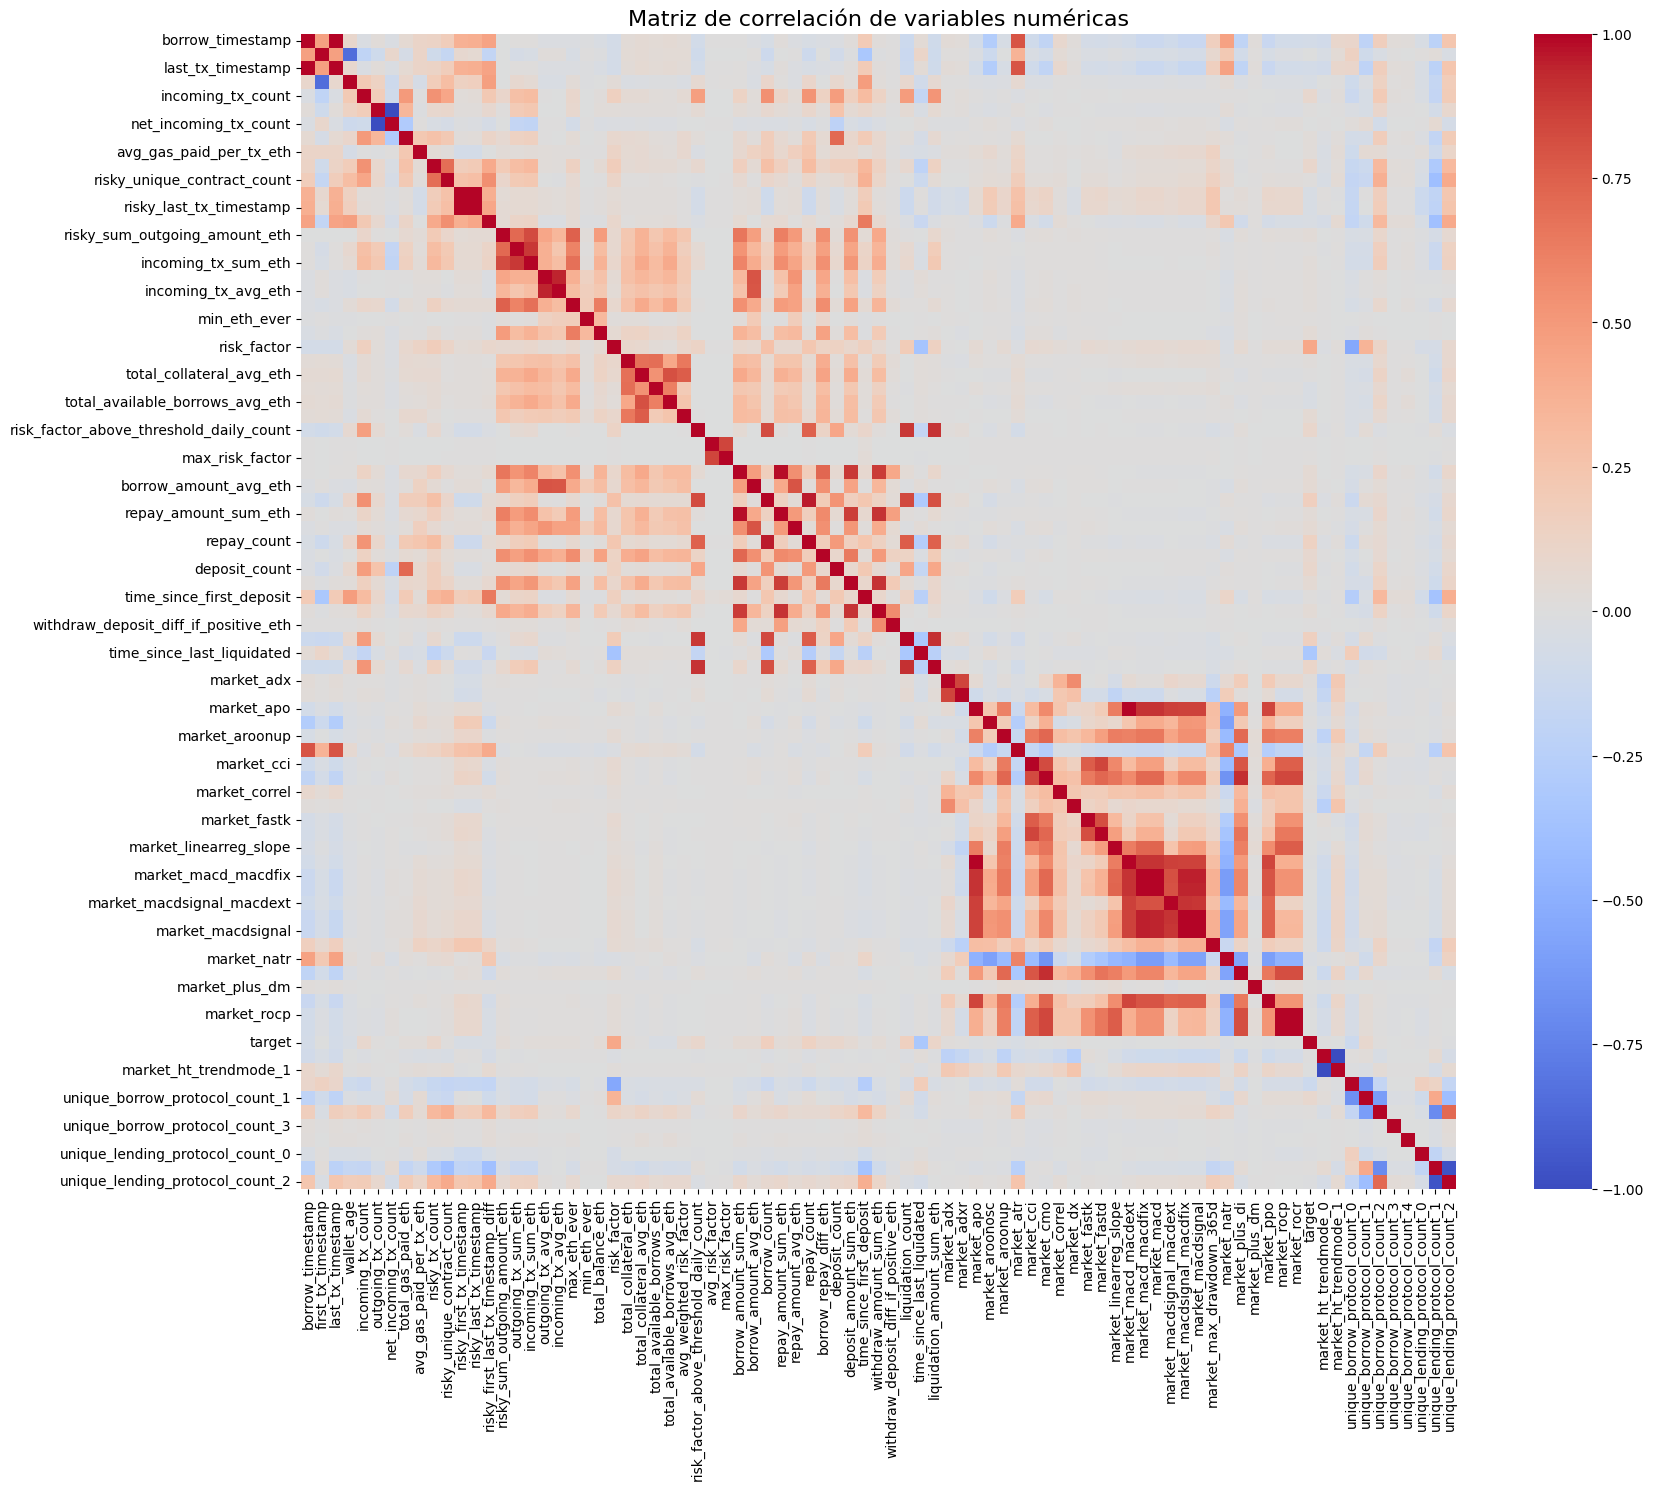

In [ ]:
# Filtramos y agregamos la correlación con y
df_corr = df.copy()


# Calcular la matriz de correlación
correlation_matrix = df_corr.corr()

# Configurar el tamaño del heatmap
plt.figure(figsize=(20, 15))

# Crear un heatmap de la matriz de correlación
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
    square=True
)

# Mostrar el heatmap
plt.title("Matriz de correlación de variables numéricas", fontsize=16)
plt.show()

Notamos inmediatamente la presencia de bloques, se correlacionan possitivamente entre sí las variables de mercado, las variables relacionadas a etherum y algunas variables de riesgo con las características de mercado. También nos fijamos que ninguna variable tiene una correlación relevante con la etiqueta, salvo total_balance_eth que parece tener la mayor.

In [ ]:
# Calculamos la cantidad de columnas con las cuales hay alta correlación para cada columna
def high_correlation_summary(df, num_cols, threshold=0.8):
    """
    Identifica columnas numéricas con alta correlación en un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        num_cols (list): Lista de nombres de columnas numéricas para evaluar.
        threshold (float): Umbral para considerar alta correlación (default 0.8).

    Returns:
        pd.DataFrame: DataFrame con columnas: 'Column', 'HighCorrelationCount', 'CorrelatedColumns'.
    """
    # Filtrar las columnas numéricas del DataFrame
    numerical_data = df[num_cols]

    # Calcular la matriz de correlación
    correlation_matrix = numerical_data.corr()

    # Crear una lista para almacenar resultados
    results = []

    for column in numerical_data.columns:
        # Filtrar columnas con alta correlación (sin incluir la diagonal principal)
        highly_correlated = correlation_matrix[
            (correlation_matrix[column] > threshold) & (correlation_matrix[column] < 1)
        ].index.tolist()

        # Agregar a la lista de resultados
        results.append({
            "Column": column,
            "HighCorrelationCount": len(highly_correlated),
            "CorrelatedColumns": highly_correlated
        })

    # Convertir los resultados en un DataFrame
    summary_df = pd.DataFrame(results)

    return summary_df

In [ ]:
# Aplicamos
summary = high_correlation_summary(df, num, threshold=0.85).sort_values(by="HighCorrelationCount", ascending=False)
summary[summary["HighCorrelationCount"]>0].reset_index()

index                                   Column  HighCorrelationCount  \
0      64                        market_macdsignal                     6   
1      63                market_macdsignal_macdfix                     6   
2      61                              market_macd                     5   
3      60                      market_macd_macdfix                     5   
4      59                      market_macd_macdext                     5   
5      48                               market_apo                     5   
6      62                market_macdsignal_macdext                     4   
7      31                    borrow_amount_sum_eth                     3   
8      34                     repay_amount_sum_eth                     3   
9      41                  withdraw_amount_sum_eth                     3   
10     39                   deposit_amount_sum_eth                     3   
11     28  risk_factor_above_threshold_daily_count                     2   
12     45               liquidation_amount_sum_eth                     2   
13     43                        liquidation_count                     2   
14     33                             borrow_count                     1   
15      0                         borrow_timestamp                     1   
16     67                           market_plus_di                     1   
17     53                               market_cmo                     1   
18     36                              repay_count                     1   
19     15                      outgoing_tx_sum_eth                     1   
20     16                      incoming_tx_sum_eth                     1   
21     11                 risky_first_tx_timestamp                     1   
22      2                        last_tx_timestamp                     1   
23     12                  risky_last_tx_timestamp                     1   
24     17                      outgoing_tx_avg_eth                     1   
25     18                      incoming_tx_avg_eth                     1   

                                    CorrelatedColumns  
0   [market_apo, market_macd_macdext, market_macd_...  
1   [market_apo, market_macd_macdext, market_macd_...  
2   [market_apo, market_macd_macdext, market_macd_...  
3   [market_apo, market_macd_macdext, market_macd,...  
4   [market_macd_macdfix, market_macd, market_macd...  
5   [market_macd_macdfix, market_macd, market_macd...  
6   [market_apo, market_macd_macdext, market_macds...  
7   [repay_amount_sum_eth, deposit_amount_sum_eth,...  
8   [borrow_amount_sum_eth, deposit_amount_sum_eth...  
9   [borrow_amount_sum_eth, repay_amount_sum_eth, ...  
10  [borrow_amount_sum_eth, repay_amount_sum_eth, ...  
11    [liquidation_count, liquidation_amount_sum_eth]  
12  [risk_factor_above_threshold_daily_count, liqu...  
13  [risk_factor_above_threshold_daily_count, liqu...  
14                                      [repay_count]  
15                                [last_tx_timestamp]  
16                                       [market_cmo]  
17                                   [market_plus_di]  
18                                     [borrow_count]  
19                              [incoming_tx_sum_eth]  
20                              [outgoing_tx_sum_eth]  
21                          [risky_last_tx_timestamp]  
22                                 [borrow_timestamp]  
23                         [risky_first_tx_timestamp]  
24                              [incoming_tx_avg_eth]  
25                              [outgoing_tx_avg_eth]

Encontramos que existen muchas variables que tienen una altísima correlación con otras, que podrían alterar el buen desempeño de un modelo sin agregar mucha información entre otros problemas de colinealidad.
Podemos decidir eliminar las variables con alta correlación en orden, de forma de dejar solo las columnas que mayor cantidad de columnas explican.

In [ ]:
# Creamos una función para identificar pares de variables con alta correlación
# de forma de encontrar variables que puedan ser explicadas por otras y
# complementen el análisis anterior.
def get_highly_correlated_vars(df, num_cols, threshold=0.85):
    """
    Encuentra pares de variables con correlación absoluta mayor al umbral especificado.

    Args:
        df (pd.DataFrame): DataFrame con las variables a analizar.
        threshold (float): Umbral de correlación.

    Returns:
        list: Lista de tuplas con pares de columnas que tienen correlación mayor al umbral.
    """
    # Filtrar las columnas numéricas del DataFrame
    numerical_data = df[num_cols]

    # Calcular la matriz de correlación
    corr_matrix = numerical_data.corr()

    # Filtra la matriz para valores superiores al umbral, excluyendo la diagonal
    high_corr_pairs = [
        (col1, col2)
        for col1 in corr_matrix.columns
        for col2 in corr_matrix.columns
        if col1 != col2 and corr_matrix.loc[col1, col2] > threshold
    ]

    return high_corr_pairs

In [ ]:
# Aplicar
high_corr_vars = get_highly_correlated_vars(df,num, threshold=0.85)

# Imprimir
print("Pares de variables con correlación alta:")
for pair in high_corr_vars:
    print(pair)

Pares de variables con correlación alta:
('borrow_timestamp', 'last_tx_timestamp')
('last_tx_timestamp', 'borrow_timestamp')
('risky_first_tx_timestamp', 'risky_last_tx_timestamp')
('risky_last_tx_timestamp', 'risky_first_tx_timestamp')
('outgoing_tx_sum_eth', 'incoming_tx_sum_eth')
('incoming_tx_sum_eth', 'outgoing_tx_sum_eth')
('outgoing_tx_avg_eth', 'incoming_tx_avg_eth')
('incoming_tx_avg_eth', 'outgoing_tx_avg_eth')
('risk_factor_above_threshold_daily_count', 'liquidation_count')
('risk_factor_above_threshold_daily_count', 'liquidation_amount_sum_eth')
('borrow_amount_sum_eth', 'repay_amount_sum_eth')
('borrow_amount_sum_eth', 'deposit_amount_sum_eth')
('borrow_amount_sum_eth', 'withdraw_amount_sum_eth')
('borrow_count', 'repay_count')
('repay_amount_sum_eth', 'borrow_amount_sum_eth')
('repay_amount_sum_eth', 'deposit_amount_sum_eth')
('repay_amount_sum_eth', 'withdraw_amount_sum_eth')
('repay_count', 'borrow_count')
('deposit_amount_sum_eth', 'borrow_amount_sum_eth')
('deposit_am

Encontramos algunas relaciones que podemos explicar a partir de lo anterior:
 - Timestamp y Block Numbers

Variables como borrow_block_number, borrow_timestamp y last_tx_timestamp están estrechamente correlacionadas porque ambas representan puntos de tiempo de eventos similares.

- Transacciones Entrantes y Salientes

Las variables como incoming_tx_count y borrow_count, repay_count o liquidation_count están correlacionadas porque representan conteos relacionados con transacciones de procesos correlacionados.

- Montos Totales y Promedios

Variables como total_collateral_eth y total_collateral_avg_eth o outgoing_tx_sum_eth y incoming_tx_sum_eth están relacionadas porque los promedios derivan de los totales.

- Indicadores Financieros

Muchas métricas de mercado como market_macd, market_macdsignal o market_ppo tienen relaciones que son bastante predecibles por su naturaleza técnica.

Finalmente para reducir la dimensionalidad, se decide eliminar variables en orden por cantidad de variables con las que se correlacionan. Es decir, mantener las variables que mayor cantidad de variables explican. En caso de empate, dejamos la variable con mayor correlación con la variable objetivo.

In [ ]:
# Agregamos la columna de correlación con la etiqueta al dataframe de variables
# altamente correlacionadas.
df_correlation = summary[summary["HighCorrelationCount"]>0].reset_index()
labels_corr = correlation_matrix["target"].reset_index().rename(columns={"index":"Column"})
df_correlation = df_correlation.merge(labels_corr, on="Column")
df_correlation

index                                   Column  HighCorrelationCount  \
0      64                        market_macdsignal                     6   
1      63                market_macdsignal_macdfix                     6   
2      61                              market_macd                     5   
3      60                      market_macd_macdfix                     5   
4      59                      market_macd_macdext                     5   
5      48                               market_apo                     5   
6      62                market_macdsignal_macdext                     4   
7      31                    borrow_amount_sum_eth                     3   
8      34                     repay_amount_sum_eth                     3   
9      41                  withdraw_amount_sum_eth                     3   
10     39                   deposit_amount_sum_eth                     3   
11     28  risk_factor_above_threshold_daily_count                     2   
12     45               liquidation_amount_sum_eth                     2   
13     43                        liquidation_count                     2   
14     33                             borrow_count                     1   
15      0                         borrow_timestamp                     1   
16     67                           market_plus_di                     1   
17     53                               market_cmo                     1   
18     36                              repay_count                     1   
19     15                      outgoing_tx_sum_eth                     1   
20     16                      incoming_tx_sum_eth                     1   
21     11                 risky_first_tx_timestamp                     1   
22      2                        last_tx_timestamp                     1   
23     12                  risky_last_tx_timestamp                     1   
24     17                      outgoing_tx_avg_eth                     1   
25     18                      incoming_tx_avg_eth                     1   

                                    CorrelatedColumns    target  
0   [market_apo, market_macd_macdext, market_macd_...  0.001199  
1   [market_apo, market_macd_macdext, market_macd_...  0.001245  
2   [market_apo, market_macd_macdext, market_macd_... -0.001882  
3   [market_apo, market_macd_macdext, market_macd,... -0.001863  
4   [market_macd_macdfix, market_macd, market_macd... -0.008563  
5   [market_macd_macdfix, market_macd, market_macd... -0.008563  
6   [market_apo, market_macd_macdext, market_macds... -0.003529  
7   [repay_amount_sum_eth, deposit_amount_sum_eth,...  0.048388  
8   [borrow_amount_sum_eth, deposit_amount_sum_eth...  0.037730  
9   [borrow_amount_sum_eth, repay_amount_sum_eth, ...  0.041365  
10  [borrow_amount_sum_eth, repay_amount_sum_eth, ...  0.053982  
11    [liquidation_count, liquidation_amount_sum_eth]  0.092763  
12  [risk_factor_above_threshold_daily_count, liqu...  0.108124  
13  [risk_factor_above_threshold_daily_count, liqu...  0.151505  
14                                      [repay_count]  0.163379  
15                                [last_tx_timestamp] -0.077127  
16                                       [market_cmo] -0.001800  
17                                   [market_plus_di] -0.007401  
18                                     [borrow_count]  0.140529  
19                              [incoming_tx_sum_eth]  0.014532  
20                              [outgoing_tx_sum_eth]  0.027492  
21                          [risky_last_tx_timestamp] -0.045793  
22                                 [borrow_timestamp] -0.076000  
23                         [risky_first_tx_timestamp] -0.046696  
24                              [incoming_tx_avg_eth]  0.026161  
25                              [outgoing_tx_avg_eth]  0.028652

In [ ]:
print(df.shape)
print(len(num))
print(len(cat))

(354368, 83)
73
10


In [ ]:
# Eliminamos las variables altamente correlacionadas opcionalmente,
# dependiendo del efecto sobre el desempeño que tiene.
# Creamos un ciclo for que para todos los nombres de columnas numéricas en la
# lista num
# mantiene el nombre de la columna actual en la columna Column del dataframe
# anterior y revisando en orden descente según el índice del dataframe,
# elimina de la lista los nombres de las columnas almacenados en la columna
# CorrelatedColumns.

elim_var = 0

if elim_var == 1:
  for column in num:
    for index, row in df_corr.iterrows():
      if column in row["CorrelatedColumns"]:
          num.remove(column)
          break

In [ ]:
# Revisamos que no hayan columnas repetidas
print(len(num))
num_set = list(set(num))
print(len(num_set))

73
73


## Creamos una copia del dataframe con las variables correlacionadas eliminadas ##

In [ ]:
# Crear una lista de columnas correlacionadas para eliminar
columns_to_remove = set(df_correlation["Column"])  # Agregar columnas principales con alta correlación

# Agregar las columnas correlacionadas adicionales
for correlated in df_correlation["CorrelatedColumns"]:
    columns_to_remove.update(correlated)

# Crear una copia de X sin las columnas correlacionadas
df_filtered = df.drop(columns=columns_to_remove, errors='ignore')

# Mostrar el resultado
print(f"Columnas eliminadas: {columns_to_remove}")
print(f"Nueva forma del DataFrame: {df_filtered.shape}")



Columnas eliminadas: {'market_apo', 'outgoing_tx_avg_eth', 'risky_first_tx_timestamp', 'risk_factor_above_threshold_daily_count', 'market_plus_di', 'market_macd_macdfix', 'liquidation_count', 'withdraw_amount_sum_eth', 'incoming_tx_sum_eth', 'market_macd_macdext', 'repay_count', 'liquidation_amount_sum_eth', 'borrow_count', 'last_tx_timestamp', 'deposit_amount_sum_eth', 'outgoing_tx_sum_eth', 'market_cmo', 'market_macdsignal_macdext', 'market_macdsignal_macdfix', 'risky_last_tx_timestamp', 'market_macdsignal', 'incoming_tx_avg_eth', 'market_macd', 'borrow_amount_sum_eth', 'borrow_timestamp', 'repay_amount_sum_eth'}
Nueva forma del DataFrame: (354368, 57)


##Outliers y valores nulos
Tratamiento de nulos

In [ ]:
df.isna().sum().sum()

0

No encontramos nulos en la data.

Eliminamos valores atípicos a través de análisis IQR.

In [ ]:
class IQR(BaseEstimator, TransformerMixin):
  """
  Clase que elimina los outliers de las
  columnas numéricas de un dataframe
  basado en los cuartiles, el rango
  intercuartílico y un parámetro de ajuste
  arbitrario.
  """
  # Constructor de la clase
  def __init__(self,lambda1):
    assert isinstance(lambda1, (int, float)) and lambda1 > 0
    self.lambda1 = lambda1

  # Método que calcula los parámetros necesarios
  # para la transformación.
  def fit(self, X, y=None):
    # Cuartiles de la columna

    self.Q1_ = X.quantile(0.25)
    self.Q2_ = X.quantile(0.5)
    self.Q3_ = X.quantile(0.75)

    # Rango intercuartil

    self.RIC_ = self.Q3_ - self.Q1_
    # Límites
    # Superior

    self.sup_ = self.Q3_ + self.lambda1*self.RIC_
    #Inferior

    self.low_ = self.Q1_ - self.lambda1*self.RIC_
    # Retornamos el objeto mismo
    return self

  # Método que realiza la transformación
  # o filtrado de los datos que elimina
  # los outliers.
  def transform(self, X):
    # Identificamos los valores que no son outliers
    mask = (X >= self.low_) & (X <= self.sup_)
    # Reemplazamos los valores outliers con NaN
    return X.where(mask)

  def set_output(self,transform='default'):
    #No modificar esta función
    return self

In [ ]:
# Pipelines
numeric_transformations = Pipeline([('outlayers_iqr',IQR(7))])
#categorical_transformations = Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))]) no es necesario imputar

# ColumnTransformer
column_transformer = ColumnTransformer([
    ('categorical', 'passthrough',cat),
    ('numerical', numeric_transformations,num)
    ],
    verbose_feature_names_out=False)

column_transformer.set_output(transform='pandas')

# Aplicamos ColumnTransformer a los datos
df_iqr = column_transformer.fit_transform(df)
df_iqr_2 = df_iqr.dropna()
print(X.shape)
df_iqr_2.shape

(354368, 75)


(149230, 83)

Vemos que perdemos muchísima información con este criterio dada la alta cantidad de columnas y los outliers detectados y el lambda de 1.5. Podemos ajustar lambda probando con 2, 3 y 5 y 7. Siendo sus resultados respectivos de datos totales los siguientes: 19946 (1.5), 27824, 43565, 68511, 74474.  Veemos que en todos los casos perdemos muchísima información y el rango intercuartílico se dilata demasiado.

Es necesario probar cómo afecta esto al rendimiento del modelo, sobre todo en conjunto con la eliminación de columnas ya omitida. Estos experimentos se realizaran posteriormente.

Queda intentar con otro método para eliminar outliers, revisemos el percentil 1 y 99.

In [ ]:
# Función para el function transformer
def remove_outliers_percentile(X, lower=0.01, upper=0.99):
    """
    Elimina outliers en las columnas numéricas de un DataFrame
    utilizando los percentiles.

    Parameters:
    - X (pd.DataFrame): DataFrame con las columnas a procesar.
    - lower (float): Percentil inferior.
    - upper (float): Percentil superior.

    Returns:
    - pd.DataFrame: DataFrame sin los outliers.
    """
    num = X.select_dtypes(include=['number'])
    lower_bounds = num.quantile(lower)
    upper_bounds = num.quantile(upper)
    mask = (num >= lower_bounds) & (num <= upper_bounds)
    return X[mask.all(axis=1)]

In [ ]:
remove_outliers_transformer = FunctionTransformer(remove_outliers_percentile)

In [ ]:
# Pipeline
numeric_transformations = Pipeline([
    ('remove_outliers', remove_outliers_transformer)
])

In [ ]:
# ColumnTransformer
column_transformer = ColumnTransformer([
    ('categorical', 'passthrough', cat),
    ('numerical', numeric_transformations, num)
], verbose_feature_names_out=False)

column_transformer.set_output(transform='pandas')

ColumnTransformer(transformers=[('categorical', 'passthrough',
                                 ['market_ht_trendmode_0',
                                  'market_ht_trendmode_1',
                                  'unique_borrow_protocol_count_0',
                                  'unique_borrow_protocol_count_1',
                                  'unique_borrow_protocol_count_2',
                                  'unique_borrow_protocol_count_3',
                                  'unique_borrow_protocol_count_4',
                                  'unique_lending_protocol_count_0',
                                  'unique_lending_protocol_count_1',
                                  'unique...
                                  'outgoing_tx_sum_eth', 'incoming_tx_sum_eth',
                                  'outgoing_tx_avg_eth', 'incoming_tx_avg_eth',
                                  'max_eth_ever', 'min_eth_ever',
                                  'total_balance_eth', 'risk_factor',
                                  'total_collateral_eth',
                                  'total_collateral_avg_eth',
                                  'total_available_borrows_eth',
                                  'total_available_borrows_avg_eth',
                                  'avg_weighted_risk_factor',
                                  'risk_factor_above_threshold_daily_count',
                                  'avg_risk_factor', ...])],
                  verbose_feature_names_out=False)

In [ ]:
# Aplicamos
df_perc = column_transformer.fit_transform(df)
df_perc_2 = df_perc.dropna()
print(df.shape)
print(df_perc_2.shape)

(354368, 83)
(211366, 83)


Este ajuste parece más razonable dado que se

In [ ]:
# Aplicamos para df sin columnas correlacionadas
#df_percentil = column_transformer.fit_transform(X_filtered)
#df_percentil_removed = df_percentil.dropna()
#print(X.shape)
#print(df_percentil_removed.shape)

## Análisis multivariado ##


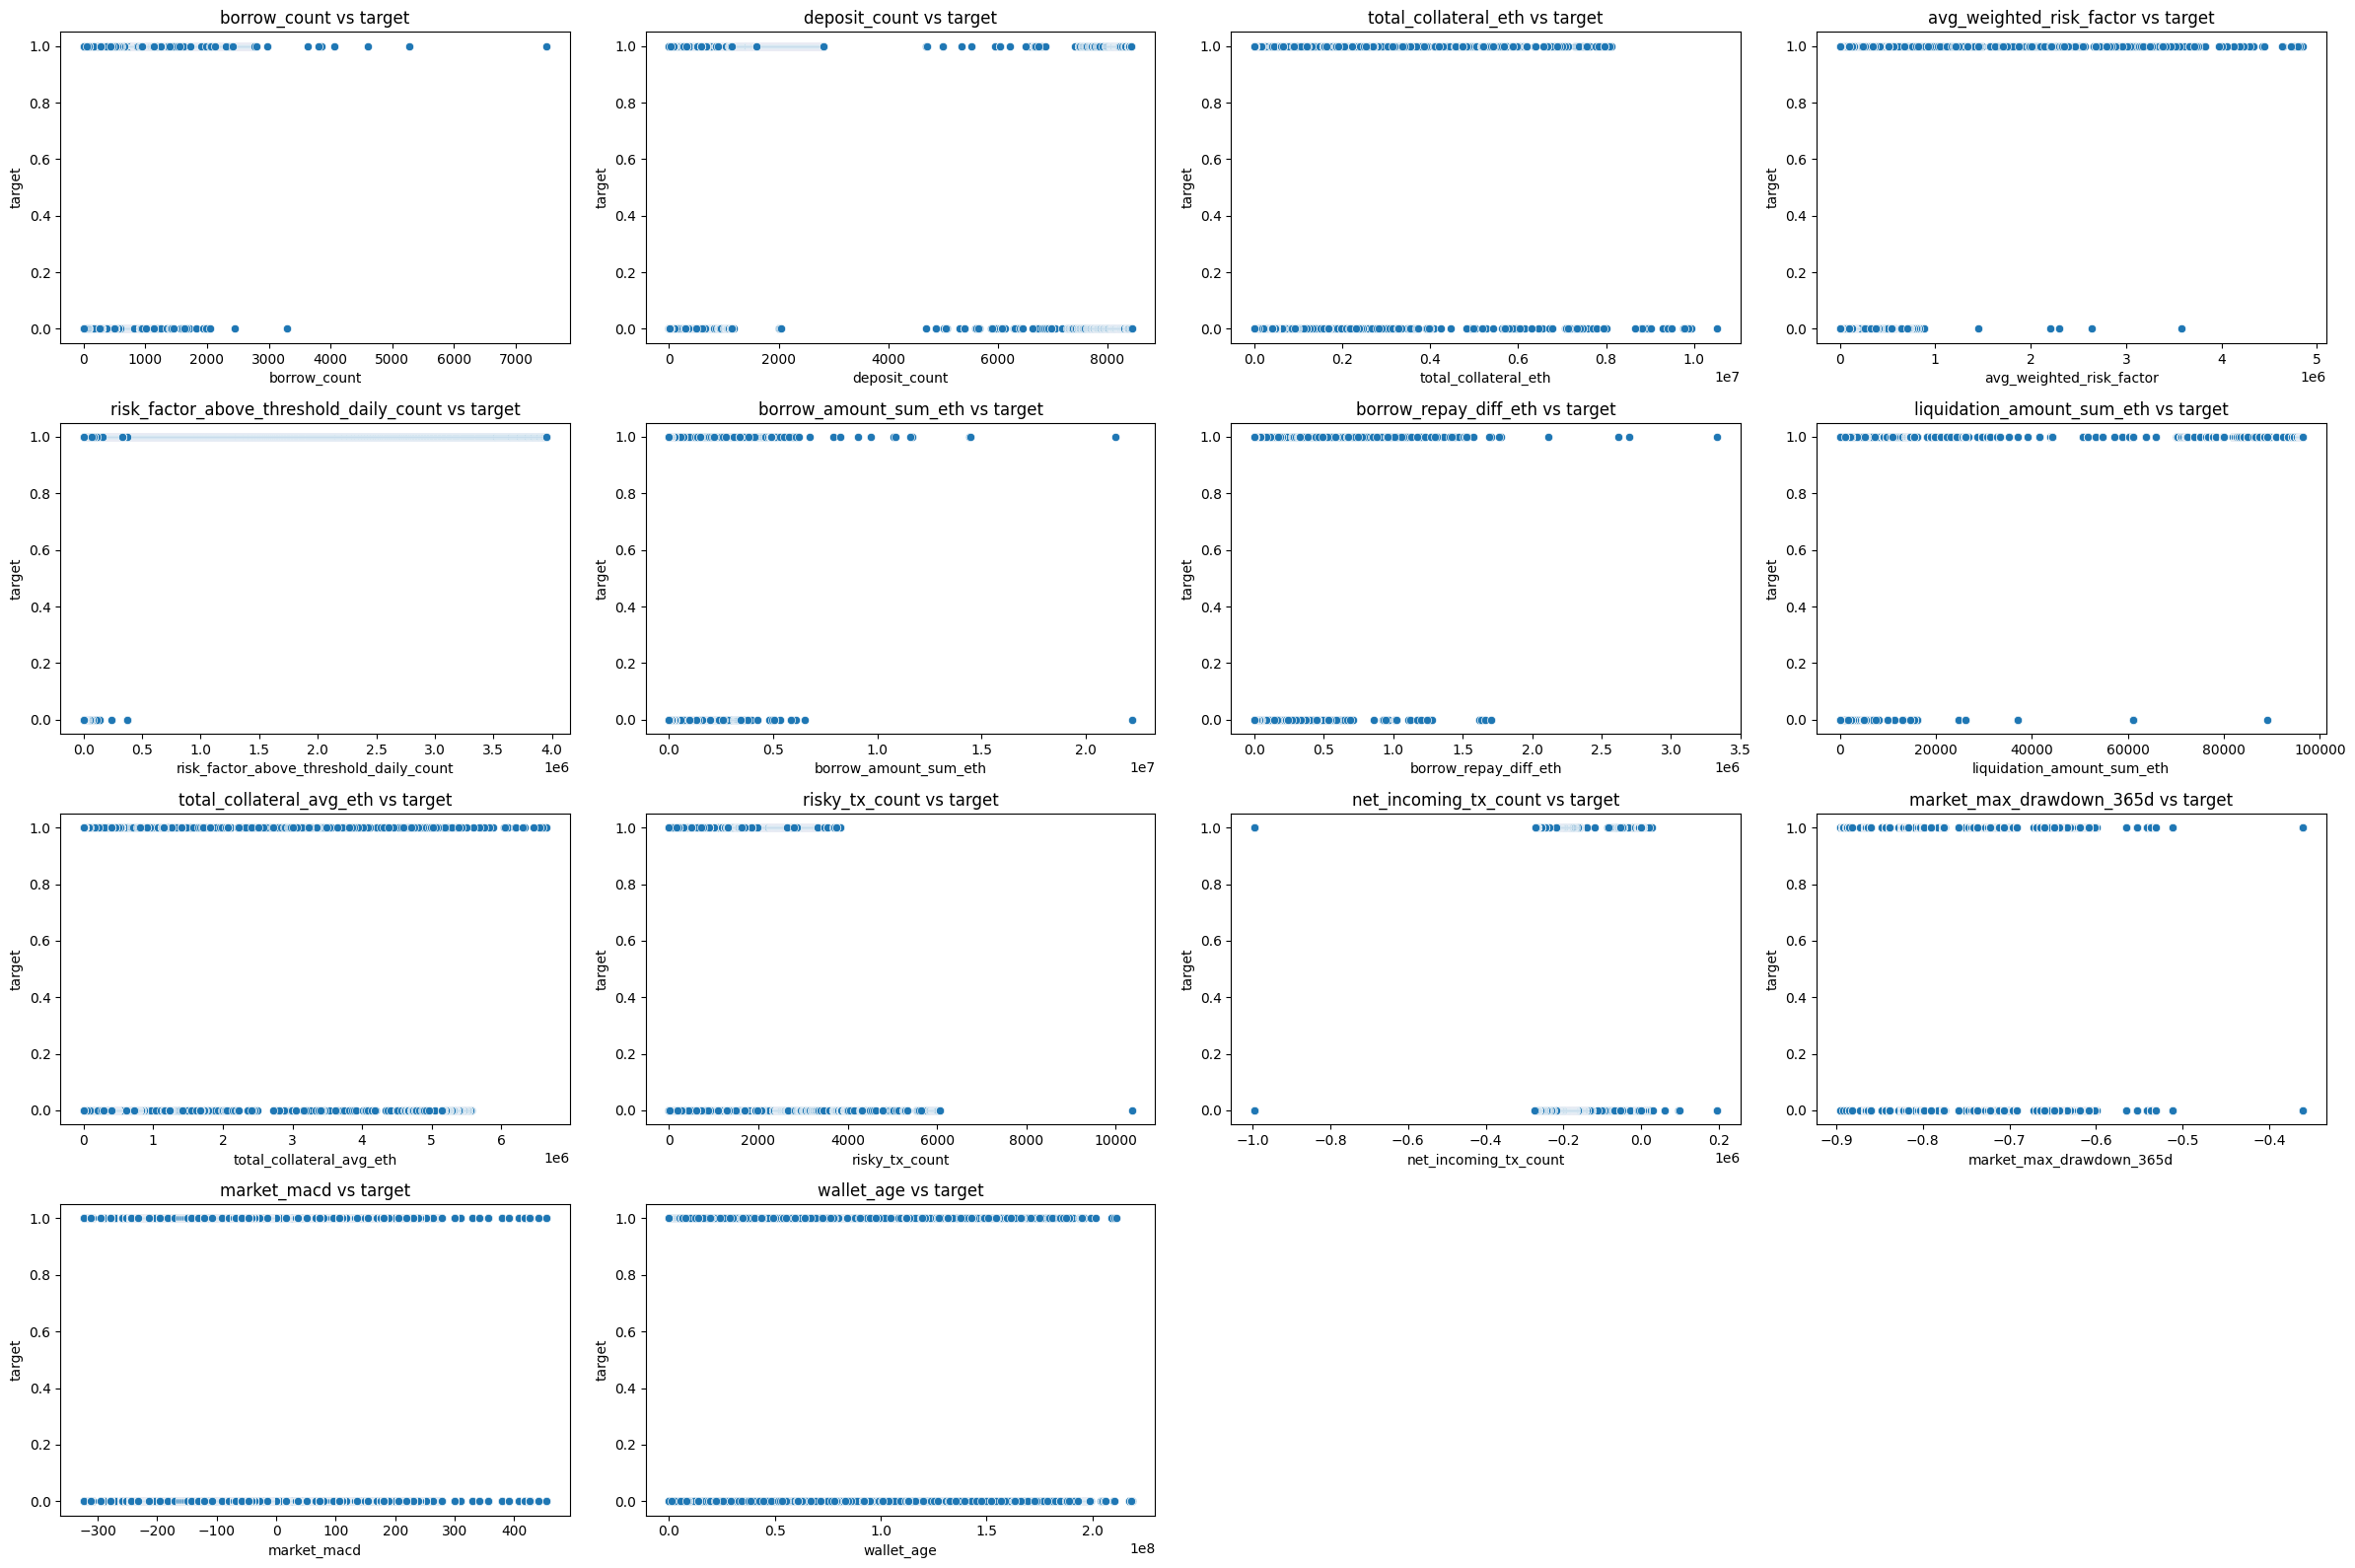

In [ ]:
def graficar_scatterplots_grandes(df, variables, target, tamaño_base=(6, 4)):
    """
    Genera scatter plots para visualizar la relación entre variables seleccionadas y la variable target.

    Args:
        df (pd.DataFrame): El DataFrame con los datos.
        variables (list): Lista de variables a graficar.
        target (str): Nombre de la variable objetivo.
        tamaño_base (tuple): Tamaño base (ancho, alto) para cada subplot.
    """
    num_variables = len(variables)
    columnas = 4  # Fijamos 4 columnas
    filas = math.ceil(num_variables / columnas)  # Calculamos las filas necesarias

    # Ajustamos el tamaño total de la figura
    tamaño_figura = (tamaño_base[0] * columnas, tamaño_base[1] * filas)

    fig, axes = plt.subplots(filas, columnas, figsize=tamaño_figura)
    axes = axes.flatten()  # Aplanamos los ejes para iterar fácilmente

    for i, var in enumerate(variables):
        sns.scatterplot(data=df, x=var, y=y['target'], ax=axes[i])
        axes[i].set_title(f"{var} vs {target}")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)

    # Ocultar subplots adicionales si los hay
    for j in range(len(variables), len(axes)):
        axes[j].axis('off')

    # Ajustar diseño y mostrar
    plt.tight_layout()
    plt.show()

# Lista de variables importantes
variables_importantes = [
    'borrow_count', 'deposit_count', 'total_collateral_eth', 'avg_weighted_risk_factor',
    'risk_factor_above_threshold_daily_count', 'borrow_amount_sum_eth', 'borrow_repay_diff_eth',
    'liquidation_amount_sum_eth', 'total_collateral_avg_eth', 'risky_tx_count',
    'net_incoming_tx_count', 'market_max_drawdown_365d', 'market_macd', 'wallet_age'
]

# Variable objetivo
target = 'target'  # Reemplaza con tu variable objetivo

# Llamada a la función
graficar_scatterplots_grandes(X, variables_importantes, target)

De estos graficos podemos notar cosas interesantes, como que, por ejemplo, la probabilidad de morosidad está más relacionada con la cantidad de préstamos que con el monto de estos. Además de la relación entre algunas variables importantes y la probabilidad de morosidad

## (Opcional) Construcción de variables ##

Finalmente, para términar con este EDA construimos algunas variables adicionales que pueden servir a la hora de prediecir la probabilidad de morosidad de un cliente

In [ ]:
def crear_variables_morosidad(df):
    """
    Crea variables basadas en literatura financiera para predecir morosidad.

    Args:
        df (pd.DataFrame): El DataFrame original o pre-procesado

    Returns:
        pd.DataFrame: El DataFrame con las nuevas variables agregadas.
    """
    df_complete = df.copy()

    # 1. Ratios financieros
    df_complete['ratio_deuda_depositos'] = df['borrow_amount_sum_eth'] / (df['deposit_amount_sum_eth'] + 1e-6)
    df_complete['ratio_deuda_ingresos'] = df['borrow_amount_sum_eth'] / (df['incoming_tx_sum_eth'] + 1e-6)
    df_complete['diferencia_ingresos_egresos'] = df['incoming_tx_sum_eth'] - df['outgoing_tx_sum_eth']
    df_complete['ratio_prestamos_pagos'] = df['borrow_amount_sum_eth'] / (df['repay_amount_sum_eth'] + 1e-6)

    # 3. Frecuencias y tendencias
    df_complete['frecuencia_uso_credito'] = df['borrow_count'] / (df['wallet_age'] + 1e-6)
    df_complete['volatilidad_transacciones'] = df['incoming_tx_sum_eth'].rolling(3).std()


    return df_complete


In [ ]:
df_complete = crear_variables_morosidad(df)

## Preprocesamiento (Eliminar) ##


Decidimos eliminar algunas columnas irrelevantes para predecir morosidad junto con aquellas columnas que tienen una alta correlación positiva.
Con respecto a las filas, debido a que gran parte de ellas tienen más de un 90% de datos faltantes (debido a las columnas con un 50% de datos faltantes) decidimos conservarlas para no peder mucha información

--- Decidimos imputar datos faltantes en las columnas con missing values, debido a que representan una gran cantidad de datos con respecto al dataset y además algunas de estas columnas pueden ser relevantes a la hora de predecir la morosidad

In [ ]:
#def eliminar_variables_correlacionadas(df, umbral=0.8):
#    """
#    Elimina variables altamente correlacionadas en un DataFrame.

#    Args:
#        df (pd.DataFrame): El DataFrame con las variables.
#        umbral (float): El umbral de correlación para considerar variables como redundantes.

#    Returns:
#        pd.DataFrame: El DataFrame con las variables redundantes eliminadas.
#        list: Lista de variables eliminadas.
#    """

#    df = df.copy()

    # Calcular la matriz de correlación
#    matriz_correlacion = df.corr()

    # Seleccionar las variables altamente correlacionadas
#    variables_a_eliminar = set()
#    for i in range(len(matriz_correlacion.columns)):
#        for j in range(i):
#            if abs(matriz_correlacion.iloc[i, j]) > umbral:
#                col1 = matriz_correlacion.columns[i]
#                col2 = matriz_correlacion.columns[j]

                # Seleccionar qué variable eliminar (por ejemplo, la segunda)
#                variables_a_eliminar.add(col2)

    # Eliminar las variables seleccionadas
#    df_reducido = df.drop(columns=variables_a_eliminar)

#    return df_reducido, list(variables_a_eliminar)

In [ ]:
#df_reducido, eliminadas = eliminar_variables_correlacionadas(df_0, umbral=0.8)

#print("Variables eliminadas por alta correlación:")
#print(eliminadas)
#print("\nDataFrame reducido:")
#print(df_reducido.head())

In [ ]:
#def eliminar_columnas_irrelevantes (df, correlation_threshold = 0.1):
#    df = df.copy()
#    correlations = df.corr()['target']
#    relevant_columns = correlations[abs(correlations) >= correlation_threshold].index.tolist()
#    df_filtered = df[relevant_columns]
#    return df_filtered , relevant_columns

In [ ]:
#eliminar_columnas_irrelevantes(df_0)

In [ ]:
# Ejemplo de uso
#df_procesado = tratar_datos(df_0, strategy_missing='median', scaler='robust')

## Entrenamiento (Eliminar) ##


In [ ]:
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import RobustScaler
#from sklearn.impute import SimpleImputer
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.base import BaseEstimator, TransformerMixin
#import pandas as pd

# Paso 1: Función para eliminar outliers
#def remove_outliers(X, y=None):
#    Q1 = X.quantile(0.25)
#    Q3 = X.quantile(0.75)
#    IQR = Q3 - Q1
#    mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
#    if y is not None:
#        return X[mask], y[mask]
#    return X[mask]

#class OutlierRemover(BaseEstimator, TransformerMixin):
#    def fit(self, X, y=None):
#        return self

#    def transform(self, X, y=None):
#        return remove_outliers(X, y)

# Paso 2: Función general que toma un DataFrame
#def train_pipeline(df, target, test_size=0.2, random_state=42):
    # Identificar columnas numéricas
#    num_cols = df.select_dtypes(include='number').columns.tolist()
#    num_cols.remove(target)  # Excluir la columna objetivo

    # Dividir en train y test
#    X = df[num_cols]
#    y = df[target]
#    X_train, X_test, y_train, y_test = train_test_split(
#        X, y, test_size=test_size, random_state=random_state
#    )

    # Paso 3: Crear el preprocesador
#    imputer = SimpleImputer(strategy='median')
#    scaler = RobustScaler()
#    preprocessor = ColumnTransformer(
#        transformers=[
#            ('num', Pipeline([('imputer', imputer), ('scaler', scaler)]), num_cols)
#        ]
#    )

    # Paso 4: Modelo
#    model = RandomForestClassifier(random_state=random_state)  # Aqui cambiar por el modelo que queramos

    # Paso 5: Crear pipeline completo
#    pipeline = Pipeline(steps=[
        #('outlier_removal', OutlierRemover()),
#        ('preprocessor', preprocessor),
#        ('model', model)
#    ])

    # Entrenar el pipeline
#    pipeline.fit(X_train, y_train)

    # Evaluar el modelo
#    train_score = pipeline.score(X_train, y_train)
#    test_score = pipeline.score(X_test, y_test)

 #   return pipeline, train_score, test_score

In [ ]:
# Ejemplo de uso
#pipeline, train_score, test_score = train_pipeline(df_0, target='target')

#print(f"Train Score: {train_score}")
#print(f"Test Score: {test_score}")

##Selección de clasificador##

En la siguiente sección se evaluará el desempeño del entrenamiento con distintos clasificadores (RandomForest, XGBoost, LightGBM y CatBoost)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

def train_pipelines(df, target, test_size=0.3, random_state=42):

    # Dividir en train y test
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Crear el preprocesador
    imputer = SimpleImputer(strategy='median')
    scaler = RobustScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('imputer', imputer), ('scaler', scaler)]), X.columns.tolist())
        ]
    )

    # Lista de modelos
    models = {
        "RandomForest": RandomForestClassifier(random_state=random_state),
        "XGBoost": XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss'),
        "LightGBM": LGBMClassifier(random_state=random_state),
        "CatBoost": CatBoostClassifier(random_state=random_state, verbose=0)
    }

    results = {}

    for name, model in models.items():
        print(f"\nEntrenando con {name}...")

        # Crear pipeline completo
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Entrenar el pipeline
        pipeline.fit(X_train, y_train)

        # Evaluar el modelo
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)

        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['model'], "predict_proba") else None

         # Calcular métricas
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "NA"
        recall = recall_score(y_test, y_pred)

        print(f"Resultados de {name}:")
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print(f"AUC: {auc:.4f}" if y_proba is not None else "AUC no disponible")
        print(f"Recall: {recall:.4f}")

        # Guardar resultados
        results[name] = {
            "pipeline": pipeline,
            "train_score": train_score,
            "test_score": test_score,
            "auc": auc,
            "recall": recall
        }

    return results


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


## Resultados con datos originales ##

In [ ]:
resultados = train_pipelines(df, target = 'target')

# Ver resultados
for modelo, info in resultados.items():
    print(f"\nModelo: {modelo}")
    print(f"Train Score: {info['train_score']:.4f}")
    print(f"Test Score: {info['test_score']:.4f}")
    print(f"Auc: {info['auc']:.4f}")
    print(f"Recall: {info['recall']:.4f}")



Entrenando con RandomForest...
Resultados de RandomForest:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     63896
           1       0.92      0.78      0.85     42415

    accuracy                           0.89    106311
   macro avg       0.90      0.87      0.88    106311
weighted avg       0.89      0.89      0.89    106311

[[61110  2786]
 [ 9160 33255]]
AUC: 0.9513
Recall: 0.7840

Entrenando con XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:58:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados de XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     63896
           1       0.87      0.72      0.79     42415

    accuracy                           0.85    106311
   macro avg       0.85      0.83      0.83    106311
weighted avg       0.85      0.85      0.84    106311

[[59207  4689]
 [11696 30719]]
AUC: 0.9159
Recall: 0.7242

Entrenando con LightGBM...
[LightGBM] [Info] Number of positive: 98793, number of negative: 149264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.473822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17684
[LightGBM] [Info] Number of data points in the train set: 248057, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398267 -> initscore=-0.412690
[LightGBM] [Info] Start training from score -0.412690
Resultados de LightGBM:
              precision    recall  f1-score

## Resultados con eliminación de variables correlacionadas ##

In [ ]:
resultados_sin_corr = train_pipelines(df_filtered, target = 'target')

# Ver resultados
for modelo, info in resultados.items():
    print(f"\nModelo: {modelo}")
    print(f"Train Score: {info['train_score']:.4f}")
    print(f"Test Score: {info['test_score']:.4f}")
    print(f"Auc: {info['auc']:.4f}")
    print(f"Recall: {info['recall']:.4f}")



Entrenando con RandomForest...
Resultados de RandomForest:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     63896
           1       0.92      0.78      0.84     42415

    accuracy                           0.88    106311
   macro avg       0.89      0.87      0.87    106311
weighted avg       0.89      0.88      0.88    106311

[[61055  2841]
 [ 9517 32898]]
AUC: 0.9478
Recall: 0.7756

Entrenando con XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:07:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados de XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     63896
           1       0.87      0.72      0.79     42415

    accuracy                           0.84    106311
   macro avg       0.85      0.82      0.83    106311
weighted avg       0.85      0.84      0.84    106311

[[59161  4735]
 [11903 30512]]
AUC: 0.9144
Recall: 0.7194

Entrenando con LightGBM...
[LightGBM] [Info] Number of positive: 98793, number of negative: 149264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11199
[LightGBM] [Info] Number of data points in the train set: 248057, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398267 -> initscore=-0.412690
[LightGBM] [Info] Start training from score -0.412690
Resultados de LightGBM:
              precision    recall  f1-score

## Resultados con eliminación de outliers (percentil 99) ##

In [ ]:
resultados_sin_outliers = train_pipelines(df_perc_2, target ='target')

# Ver resultados
for modelo, info in resultados.items():
    print(f"\nModelo: {modelo}")
    print(f"Train Score: {info['train_score']:.4f}")
    print(f"Test Score: {info['test_score']:.4f}")
    print(f"Auc: {info['auc']:.4f}")
    print(f"Recall: {info['recall']:.4f}")



Entrenando con RandomForest...
Resultados de RandomForest:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     39703
         1.0       0.91      0.75      0.82     23707

    accuracy                           0.88     63410
   macro avg       0.89      0.85      0.87     63410
weighted avg       0.88      0.88      0.88     63410

[[37919  1784]
 [ 5815 17892]]
AUC: 0.9430
Recall: 0.7547

Entrenando con XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados de XGBoost:
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88     39703
         1.0       0.85      0.71      0.78     23707

    accuracy                           0.85     63410
   macro avg       0.85      0.82      0.83     63410
weighted avg       0.85      0.85      0.84     63410

[[36840  2863]
 [ 6879 16828]]
AUC: 0.9128
Recall: 0.7098

Entrenando con LightGBM...
[LightGBM] [Info] Number of positive: 55368, number of negative: 92588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17366
[LightGBM] [Info] Number of data points in the train set: 147956, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374219 -> initscore=-0.514158
[LightGBM] [Info] Start training from score -0.514158
Resultados de LightGBM:
              precision    recall  f1-score 

## Resultados con eliminación de outliers (percentil 99) y eliminación de variables ##

In [ ]:
# Llamar a la función con un DataFrame
#resultados = train_pipelines(df_percentil_removed, target='target')

# Ver resultados
#for modelo, info in resultados.items():
#    print(f"\nModelo: {modelo}")
#    print(f"Train Score: {info['train_score']:.4f}")
#    print(f"Test Score: {info['test_score']:.4f}")
#    print(f"Auc: {info['auc']:.4f}")
#    print(f"Recall: {info['recall']:.4f}")

## Resultados con variables adicionales incluidas ##

In [ ]:
resultados_complete = train_pipelines(df_complete, target='target')

# Ver resultados
for modelo, info in resultados.items():
    print(f"\nModelo: {modelo}")
    print(f"Train Score: {info['train_score']:.4f}")
    print(f"Test Score: {info['test_score']:.4f}")
    print(f"Auc: {info['auc']:.4f}")
    print(f"Recall: {info['recall']:.4f}")


Entrenando con RandomForest...
Resultados de RandomForest:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     63896
           1       0.92      0.78      0.85     42415

    accuracy                           0.89    106311
   macro avg       0.90      0.87      0.88    106311
weighted avg       0.89      0.89      0.88    106311

[[61166  2730]
 [ 9313 33102]]
AUC: 0.9500
Recall: 0.7804

Entrenando con XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados de XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     63896
           1       0.87      0.73      0.79     42415

    accuracy                           0.85    106311
   macro avg       0.85      0.83      0.84    106311
weighted avg       0.85      0.85      0.84    106311

[[59280  4616]
 [11618 30797]]
AUC: 0.9172
Recall: 0.7261

Entrenando con LightGBM...
[LightGBM] [Info] Number of positive: 98793, number of negative: 149264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.305724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19214
[LightGBM] [Info] Number of data points in the train set: 248057, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398267 -> initscore=-0.412690
[LightGBM] [Info] Start training from score -0.412690
Resultados de LightGBM:
              precision    recall  f1-score

A partir de los resultados obtenidos, podemos notar claramente que el mejor desempeño en cuanto a AUC, que es la métrica a optimizar en este caso, se obtiene al utilizar los datos del dataframe original, es decir, los datos sin eliminación de outliers, sin eliminación de columnas y sin la incorporación de variables adicionales.

# Reentrenamiento y Tracking #

In [ ]:
#import mlflow

ModuleNotFoundError: No module named 'mlflow'

In [ ]:
# Configuración de MLFlow
#mlflow.set_tracking_uri("http://localhost:5000")  # Cambiar según configuración local o remota
#mlflow.set_experiment("Reentrenamiento y Optimización")

#    """
#    Realiza un entrenamiento incremental con RandomForestClassifier utilizando partial_fit.

#    Args:
#        df (pd.DataFrame): Datos de entrada.
#        target (str): Columna objetivo.
#        previous_model (RandomForestClassifier, optional): Modelo previamente entrenado.
#        test_size (float): Proporción de datos para prueba.
#        random_state (int): Semilla para reproducibilidad.

#    Returns:
#        dict: Resultados incluyendo modelo actualizado y métricas.
#    """
#    X = df.drop(columns=[target])
#    y = df[target]
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#    with mlflow.start_run():
        # Cargar modelo previo o inicializar uno nuevo
#        if previous_model:
#            model = previous_model
#        else:
#            model = RandomForestClassifier(warm_start=True, random_state=random_state, n_jobs=-1)

        # Configurar warm_start para entrenamiento incremental
#        if hasattr(model, "warm_start"):
#            model.warm_start = True

        # Entrenamiento incremental
#        model.fit(X_train, y_train)

        # Métricas
#        y_pred_proba = model.predict_proba(X_test)[:, 1]
#        auc = roc_auc_score(y_test, y_pred_proba)

#        print("\nClassification Report:\n", classification_report(y_test, model.predict(X_test)))
#        print(f"AUC: {auc:.4f}")

        # Registrar modelo y métricas en MLFlow
#        mlflow.log_param("test_size", test_size)
#        mlflow.log_metric("AUC", auc)
#        mlflow.sklearn.log_model(model, artifact_path="model")

#    return {"model": model, "auc": auc}

## Optimización de Hiperparámetros ##

De la sección anterior, encontramos que el mejor desempeño de entrenamiento se logra con Random Forest. Luego, en esta sección se intentará mejorar este desempeño mediante la optimización de los hiperparámetros n_estimators, max_depth, min_samples_split, min_samples_leaf y max_features mediante la utilización de Optuna.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, recall_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
!pip install MLFlow
import mlflow
import mlflow.sklearn

def objective(trial, X_train, y_train):

    """Función objetivo para optimizar Random Forest con Optuna."""

    # Definimos el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Crear el modelo con n_jobs=4 para usar solo 4 núcleos por trial
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=4,  # 4 núcleos por modelo
        random_state=42
    )

    # Validación cruzada para evaluar el modelo
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=1).mean()  # No paralelizar CV, cambiar scoring a "recall" si es que decidimos optimizar el recall
    return score

def train_random_forest_with_optuna(df, target, test_size=0.3, random_state=42, n_trials=50):

    # Dividir en train y test
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Crear el preprocesador
    imputer = SimpleImputer(strategy="median")
    scaler = RobustScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", imputer), ("scaler", scaler)]),  X.columns.tolist())
        ]
    )

    # Optuna: Ejecutar 3 trials en paralelo para usar un total de 14 núcleos
    print("Optimizando hiperparámetros con Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials, n_jobs=3)  # 3 trials simultáneos

    # Mejor conjunto de hiperparámetros
    best_params = study.best_params
    print("\nMejores hiperparámetros encontrados:")
    print(best_params)

    # Entrenar el modelo con los mejores hiperparámetros
    model = RandomForestClassifier(**best_params, n_jobs=4, random_state=random_state)  # 4 núcleos para entrenamiento
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)

    # Evaluar el modelo
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidades para calcular AUC
    auc = roc_auc_score(y_test, y_proba)
    recall = recall_score(y_test, y_pred)

    print("\nResultados del modelo optimizado:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"AUC: {auc:.4f}")
    print(f"Recall: {recall:.4f}")

    # Tracking en MLFlow
    mlflow.set_experiment("RandomForest_Optimization")
    with mlflow.start_run():
        mlflow.log_params(best_params)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("recall", recall)
        mlflow.sklearn.log_model(pipeline, "random_forest_model")

    # Retornar resultados
    return {
        "pipeline": pipeline,
        "best_params": best_params,
        "auc": auc,
        "recall": recall,
        "study": study
    }


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.6 MB/s eta 0:00:00


In [ ]:
results_optuna = train_random_forest_with_optuna(df, target = "target", n_trials = 3) # Se puede aumentar el numero de trials para ver si se encuentran mejores hiperparametros

[I 2024-12-12 08:24:14,110] A new study created in memory with name: no-name-ecc30d4a-ecbd-49a7-859c-80dad930306e


Optimizando hiperparámetros con Optuna...


[I 2024-12-12 09:35:27,477] Trial 0 finished with value: 0.9409098144658895 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9409098144658895.


Dejamos el número de trials en 3, para reducir los tiempos de ejecución, sin embargo se recomienda aumentar el número de trials y ejecutarlo en un entorno local (en un equipo con mínimo 16 núcleos) para así encontrar mejores configuraciones de hiperparámetros

## Tracking en MlFlow ##

In [ ]:
from pyngrok import ngrok

# Abre el servidor de MLFlow UI
mlflow.set_tracking_uri("file:/content/mlruns")
mlflow_ui_url = ngrok.connect(5000, "http")
print(f"MLFlow UI disponible en: {mlflow_ui_url}")
!mlflow ui --port 5000 --host 0.0.0.0 &


## A continuación analizaremos la importancia de los hiperparametros en el rendimiento del modelo ##

In [ ]:
from optuna.visualization import plot_param_importances, plot_optimization_history
import optuna

# Visualizar la importancia de los hiperparámetros
def analyze_hyperparameter_importance(study):
    """
    Analiza y visualiza la importancia de los hiperparámetros en el rendimiento.

    Args:
        study (optuna.study.Study): Estudio de Optuna que contiene los resultados de la optimización.

    Returns:
        None
    """
    print("\nAnálisis de importancia de hiperparámetros:")

    # Mostrar la importancia en texto
    param_importances = optuna.importance.get_param_importances(study)
    for param, importance in param_importances.items():
        print(f"{param}: {importance:.4f}")

    # Visualización de la importancia de los parámetros
    importance_fig = plot_param_importances(study)
    importance_fig.show()

    # Visualización de la historia de optimización
    history_fig = plot_optimization_history(study)
    history_fig.show()

In [ ]:
study = results_optuna["study"]
analyze_hyperparameter_importance(study)

# Evaluación #

Mosrtramos las características más relevantes para el clasificador, como guía para tomar la decisión de eliminar algunas variables

In [ ]:
def get_random_forest_feature_importance(df, target, test_size=0.3, random_state=42):
    """
    Entrena un modelo Random Forest y retorna la importancia de características.

    Args:
        df (pd.DataFrame): DataFrame con las características y la variable objetivo.
        target (str): Nombre de la columna objetivo.
        test_size (float): Proporción del conjunto de prueba (default 0.3).
        random_state (int): Semilla para reproducibilidad (default 42).

    Returns:
        pd.DataFrame: DataFrame con columnas 'Feature' e 'Importance'.
    """
    # Dividir el DataFrame en conjunto de entrenamiento y prueba
    X = df.drop(columns=[target])
    y = df[target]
    X_train, _, y_train, _ = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Entrenar el modelo Random Forest
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    # Extraer la importancia de las características
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    return importance_df


importance_df = get_random_forest_feature_importance(df_complete, target='target')
print(importance_df)

In [ ]:
pd.set_option('display.max_rows', None)
importance_df

## Aplicación Web ##

In [ ]:
#!pip install fastapi uvicorn gradio ngrok colabcode

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from colabcode import ColabCode
import gradio as gr
import joblib

In [ ]:
# Guardar el DataFrame como un archivo CSV
df.to_csv("data.csv", index=False)

In [ ]:
# Backend con FastAPI
app = FastAPI()

class InputData(BaseModel):
    features: dict

model = None

@app.post("/predict")
async def predict(data: InputData):
    global model
    input_df = pd.DataFrame([data.features])
    prediction = model.predict(input_df)
    return {"prediction": int(prediction[0])}

# Iniciar backend en Colab
colab_backend = ColabCode(port=8000, code=False)

# Paso 5: Frontend con Gradio
def gradio_predict(**features):
    input_data = pd.DataFrame([features])
    pred = model.predict(input_data)[0]
    return f"Predicción: {int(pred)}"

features_list = [gr.Number(label=col) for col in df.columns if col != target]
frontend = gr.Interface(fn=gradio_predict, inputs=features_list, outputs="text")

# Paso 6: Integración y ejecución
if __name__ == "__main__":
    # Entrenar modelo y guardar
    data = pd.read_csv("data.csv")  # Reemplaza con tu dataset
    target = "target_column"       # Reemplaza con tu columna objetivo
    results = train_random_forest_with_optuna(data, target)

    model = results["pipeline"]
    joblib.dump(model, "model.pkl")

    # Iniciar backend y frontend
    colab_backend.run_app(app)
    frontend.launch()


## Back End (Fast API) ##


In [ ]:
!pip install fastapi
!pip install uvicorn

## Front End (Gradio) ##

In [ ]:
!pip install gradio --upgrade